In [ ]:
!pip install yfinance

#### Important imports and Downloading the database

In [12]:

import yfinance as yf
import pandas as pd
from datetime import datetime
import numpy as np

nifty50_symbol = "^NSEI"

data = yf.download(nifty50_symbol, start=datetime(2010, 1, 1), end=datetime(2019, 6, 30))
data.to_csv(f"{nifty50_symbol}.csv")

[*********************100%%**********************]  1 of 1 completed


### Scaling the data

In [13]:
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('^NSEI.csv')
df.head()
data = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [16]:
time_step = 60
X, y = [], []

for i in range(time_step, len(scaled_data)):
    X.append(scaled_data[i-time_step:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

### Spliting Trainig and test data

In [17]:
training_data_len = int(np.ceil(len(scaled_data) * 0.8))

train_data = scaled_data[0:int(training_data_len), :]

test_data = scaled_data[training_data_len - time_step:, :]

X_test = []
y_test = data[training_data_len:, :] 

for i in range(time_step, len(test_data)):
    X_test.append(test_data[i-time_step:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


### Defining the model

In [18]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\vaibh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Making predictions

In [19]:
model.fit(X, y, batch_size=1, epochs=1)
predictions = model.predict(X_test)

predictions = scaler.inverse_transform(predictions)


2261/2261 ━━━━━━━━━━━━━━━━━━━━ 65s 26ms/step - loss: 0.0034
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


#### RMS Error

In [20]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 176.75595375669494


### Plot of Predictions vs actual

C:\Users\vaibh\AppData\Local\Temp\ipykernel_26068\2637046153.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


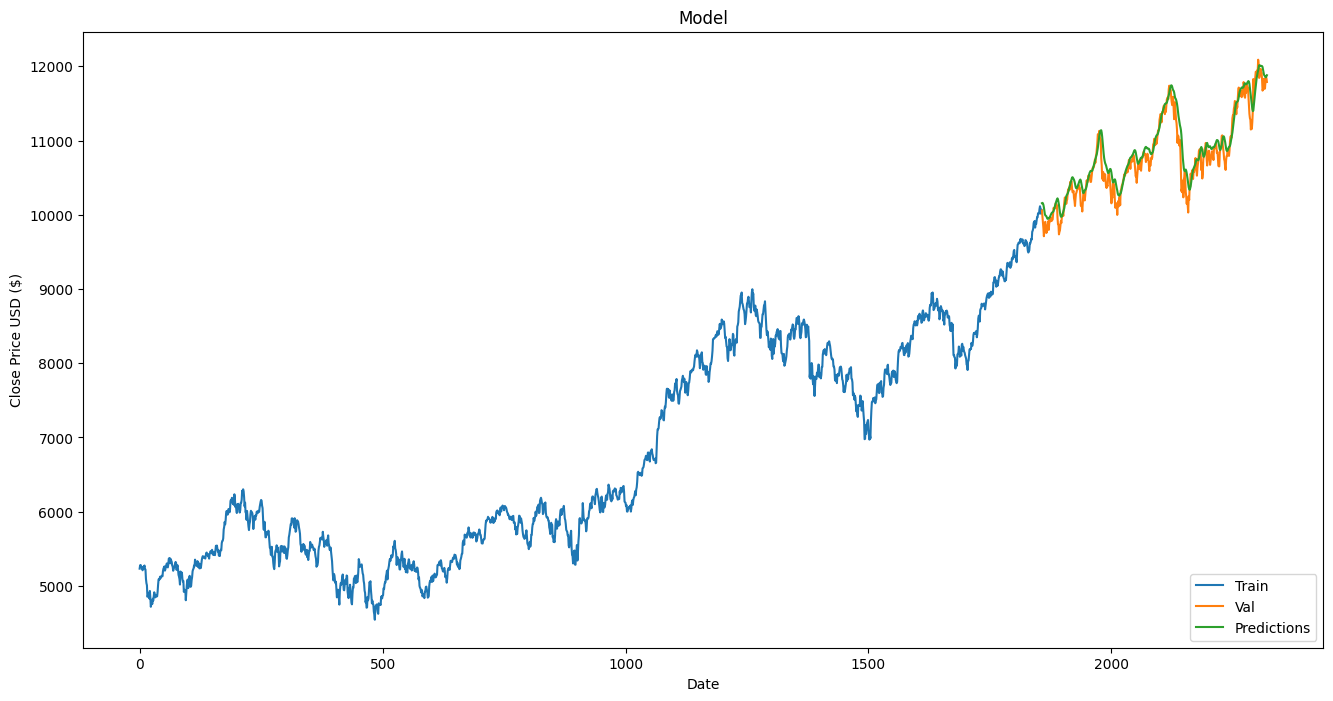

In [21]:
import matplotlib.pyplot as plt

train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()